In [3]:
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

## Prepare the Data for Analysis

Once a suitable data set has been collected, it is now time to analyze the data and see if we can identify the xxx


### Load data into MNE objects

[MNE](https://martinos.org/mne/stable/index.html) is a very powerful Python library for analyzing EEG data. It provides helpful functions for performing key tasks such as filtering EEG data, rejecting artifacts, and grouping EEG data into chunks (epochs).

The first step to using MNE is to read the data we've collected into an MNE `Raw` object

In [24]:
raw = utils.load_data('../data/subjects/', sfreq=256., 
                      subject_nb=3, session_nb=[1,2])

Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30564
    Range : 0 ... 30563 =      0.000 ...   119.387 secs
Ready.


### Visualizing the Power Spectrum

Plotting the power spectral density (PSD) of our dataset will give us a glimpse at the different frequencies that are present. We won't be able to see the N170 in the PSD, but it will give us an impression of how noisy our data was. A very noisy or flat PSD may represent poor signal quality at certain electrodes



Effective window size : 8.000 (s)


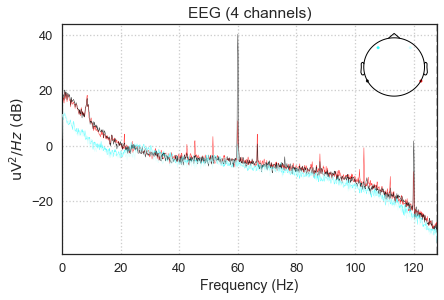

In [25]:
%matplotlib inline
raw.plot_psd();

This PSD looks good. There is a large peak at 60hz, representing background electrical activity.

### Filtering

Most ERP components are composed of lower frequency fluctuations in the EEG signal. Thus, we can filter out all frequencies between 1 and 30 hz in order to increase our ability to detect them.

Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Effective window size : 8.000 (s)


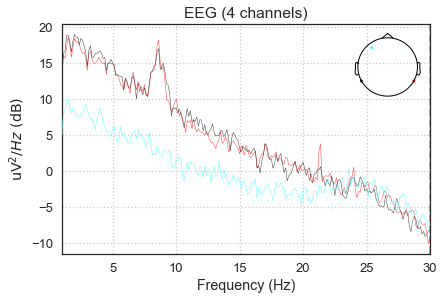

In [26]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

This PSD of frequencies between 1 and 30 hz looks good. The difference between the temporal channels (red and black) and the frontal channels (blue and green) is clearly evident. The huge peak from 1 to 3hz is largely due to the presence of eye blinks, which produce large amplitude, low-frequency events in the EEG.

### Epoching

Next, we will chunk (epoch) the data into segments representing the data 100ms before to 800ms after each stimulus. No baseline correction is needed (signal is bandpass filtered) and we will reject every epoch where the amplitude of the signal exceeded 75 uV, which should most eye blinks.

In [27]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'Positive': 1, 'Neutral': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 375e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

214 events found
Event IDs: [1 2]
sample drop %:  0.9345794392523366


<Epochs  |   212 events (all good), -0.101562 - 0.800781 sec, baseline off, ~1.5 MB, data loaded,
 'Neutral': 95
 'Positive': 117>

Sample drop % is an important metric representing how noisy our data set was. If this is greater than 20%, consider ensuring that signal variances is very low in the raw EEG viewer and collecting more data

## Step 6: Analyze the Data

Finally, we can now analyze our results by averaging the epochs that occured during the different stimuli and looking for differences in the waveform


### Epoch average

With our `plot_conditions` utility function, we can plot the average ERP for all electrodes for both conditions:

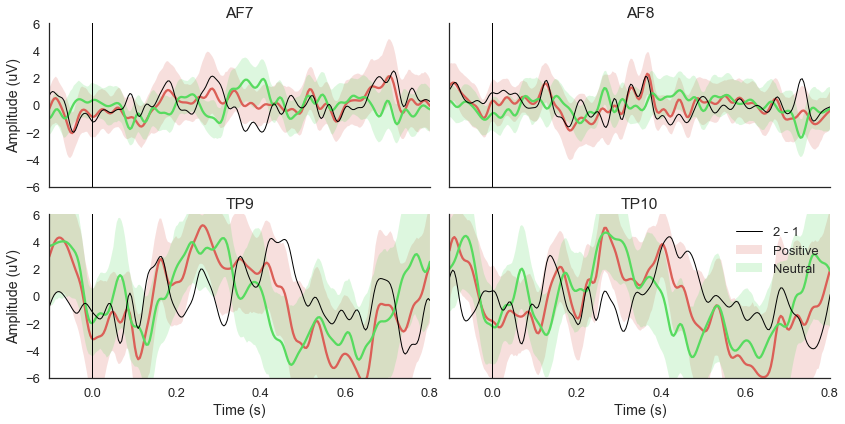

In [28]:
%matplotlib inline
conditions = OrderedDict()
conditions['Positive'] = [2]
conditions['Neutral'] = [1]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2),
                               ylim=(-6, 6))

Here we have a very nice deflection in the temporal channels around 200ms for face stimuli. This is likely the N170, although appearing slightly later due to delay in receiving the data over bluetooth. 

There's not much to see in the frontal channels (AF7 and AF8), but that's to be expected based on the fact that the N170 is mostly a lateral posterior brain phenomenon